In [1]:
import numpy as np
import imutils
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def detect_people(frame, net, ln, personIdx=0):
    (H, W) = frame.shape[:2]
    results = []

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    centroids = []
    confidences = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if classID == personIdx and confidence > 0.3:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.3)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            r = (confidences[i], (x, y, x + w, y + h), centroids[i])
            results.append(r)

    return results

In [3]:
def draw_box(frame, labels, net, ln):
    results = detect_people(frame, net, ln, personIdx=labels.index("person"))

    for (i, (prob, bbox, centroid)) in enumerate(results):
        (startX, startY, endX, endY) = bbox
        (cX, cY) = centroid
        color = (0, 255, 0)

        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 1)

    if len(results)>=10:
        color = (255, 0, 0)

    text = "Crowd Count: {}".format(len(results))
    cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)

    return frame

In [4]:
def for_image(img, labels, net, ln):
    img = Image.open(img)
    frame = np.array(img)
    frame = imutils.resize(frame, width=700)
    frame = draw_box(frame, labels, net, ln)
    
    plt.figure(figsize=(15,15))
    plt.imshow(frame)

In [5]:
def for_video(vs, labels, net, ln):
    
    f_count=0
    p_count=0
    count_list=[]

    while True:
                
        (grabbed, frame) = vs.read()
        
        f_count+=1

        if not grabbed:
            break
        
        if f_count%20!=0:
            continue

        frame = imutils.resize(frame, width=700)
        results = detect_people(frame, net, ln, personIdx=labels.index("person"))
        
        if len(results)>8:
            count_list.append(len(results))
        else:
            count_list.clear()
        
        for (i, (prob, bbox, centroid)) in enumerate(results):
            (startX, startY, endX, endY) = bbox
            (cX, cY) = centroid
            color = (0, 255, 0)

            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 1)
        
        if len(results)>=10:
            color = (255,0,0)
        else:
            color = (0,255,0)
        
        
        if len(count_list)>=10:
            p_count+=1
            text = "Alert: Getting Crowded, Please Spread Out"
            color=(255,0,0)
            
            if p_count==6:
                p_count=0
                count_list.clear()
        else:
            text = "Crowd Count: {}".format(len(results))
            
        cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 3)
        
        cv2.imshow('output',frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("x"):
            break
    cv2.destroyAllWindows()

In [6]:
labels = None
with open('..\models/coco.names', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

weightsPath = '..\models/yolov3.weights'
configPath = '..\models/yolov3.cfg'
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

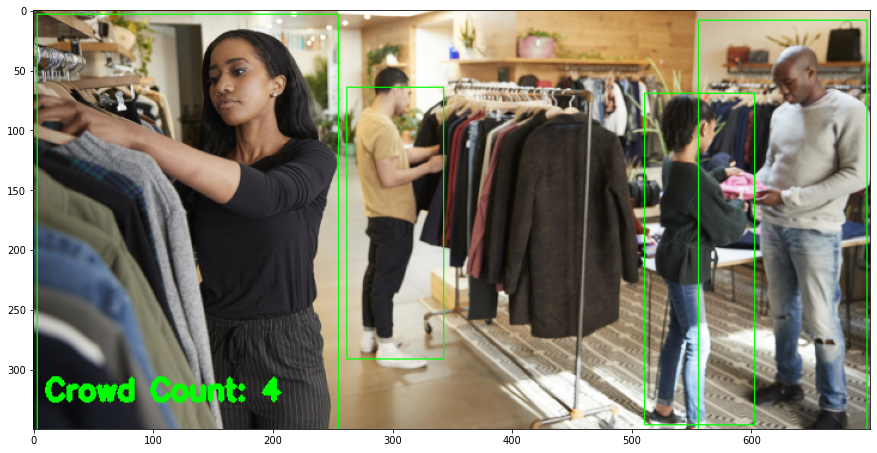

In [7]:
#IMAGE
img = '..\images/22.jpg'
for_image(img, labels, net, ln)

In [8]:
#VIDEO
video_path = '..\images/789.mp4'
vs = cv2.VideoCapture(video_path)
for_video(vs, labels, net, ln)